<a href="https://colab.research.google.com/github/JumperWacky/cycleGAN/blob/main/simple_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import torch
import torch.nn as nn

import pandas
import matplotlib.pyplot as plt
import random

import numpy as np

In [4]:
def generate_real():
  real_data = torch.FloatTensor(
      [random.uniform(0.8, 1.2),
      random.uniform(0.0, 0.2),
      random.uniform(0.8, 1.0),
      random.uniform(0.0, 0.2)])
  return real_data
print(generate_real())

def generate_random(size=4):
  random_data = torch.rand(size)
  return random_data

print(generate_random(4))

tensor([1.1374e+00, 2.6679e-04, 9.4274e-01, 9.9781e-02])
tensor([0.7831, 0.3580, 0.0073, 0.6854])


In [5]:
# 构造鉴别器
class Discriminator(nn.Module):
  def __init__(self) -> None:
    super().__init__()

    # 定义神经网路层
    self.model = nn.Sequential(
        nn.Linear(4, 3),
        nn.Sigmoid(),
        nn.Linear(3, 1),
        nn.Sigmoid()
    )

    # 创建损失函数
    self.loss_function = nn.MSELoss()

    # 创建优化器
    self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01)

    # 计数器和进程记录
    self.counter = 0
    self.progress = []

    pass
  
  def forward(self, inputs):
    return self.model(inputs)
  
  def train(self, inputs, targets):
    # 计算网络的输出值
    outputs = self.forward(inputs)
    # 计算损失值
    loss = self.loss_function(outputs, targets)

    # 梯度归零，反向传播，更新权重
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    # 每隔10个训练样本增加一次计数器的值，并将损失值添加进列表的末尾
    self.counter += 1
    if(self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass
    if(self.counter % 10000 == 0):
      print("dicriminator counter = ", self.counter)
      pass
  
  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0,1.0), figsize=(16,8), alpha=0.1, marker='.',
        grid=True, yticks=(0,0.25,0.5))
    pass

counter =  10000
counter =  20000


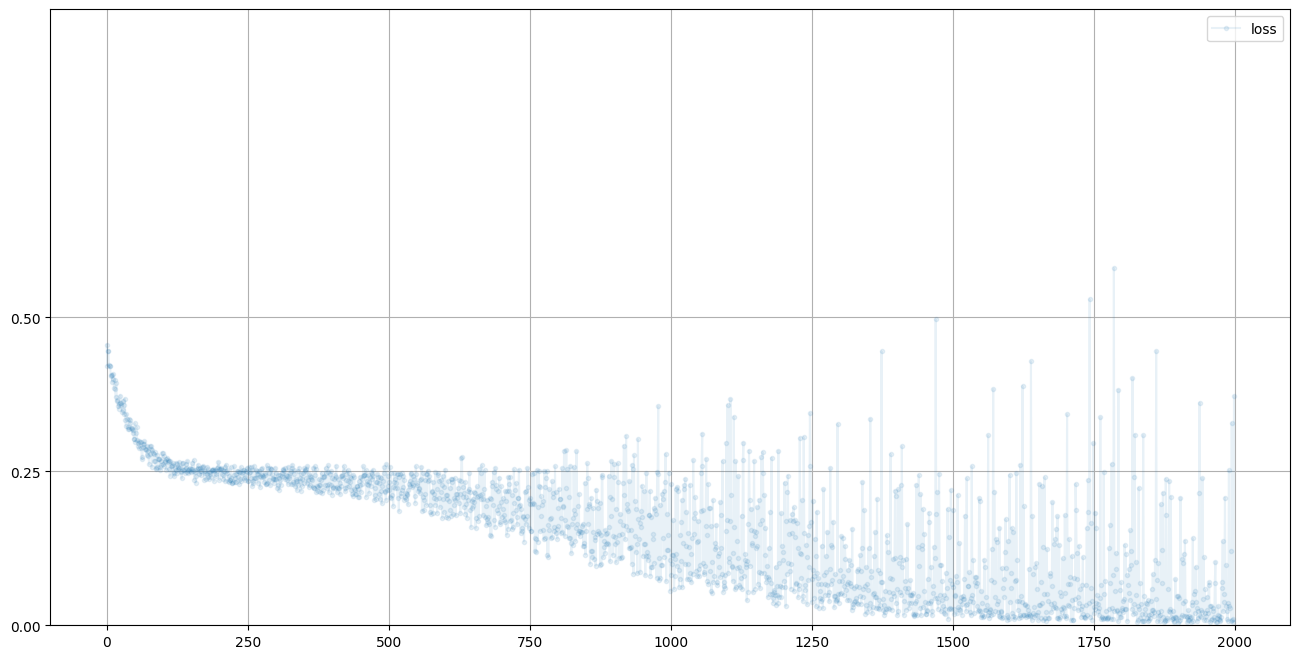

In [21]:
# 训练
D = Discriminator()

for i in range(10000):
  # 真实数据
  D.train(generate_real(), torch.FloatTensor([1.0]))
  # 随机数据
  D.train(generate_random(4), torch.FloatTensor([0.0]))
  pass

D.plot_progress()


In [26]:
print(D.forward(generate_real()).item())
print(D.forward(generate_random(4)).item())

0.7871001958847046
0.1441114842891693


In [17]:
# 构造生成器
class Generator(nn.Module):
  def __init__(self):
    super().__init__()

    # 定义神经网路层
    self.model = nn.Sequential(
        nn.Linear(1, 3),
        nn.Sigmoid(),
        nn.Linear(3, 4),
        nn.Sigmoid()
    )

    # 创建优化器
    self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01)  # 使用的是生成器的parameters

    # 计数器和进程记录
    self.counter = 0
    self.progress = []

    pass
  
  def forward(self, inputs):
    return self.model(inputs)
  
  def train(self, D, inputs, targets):
    # 计算生成器网络输出
    g_output = self.forward(inputs)

    # 输入鉴别器
    d_output = D.forward(g_output)

    # 计算损失值
    loss = D.loss_function(d_output, targets)
    # 每训练10次增加计数器
    self.counter += 1
    if (self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass
    if (self.counter % 10000 == 0):
      print("generator counter = ", self.counter)
      pass
    
    # 梯度归零，反向传播，更新权重
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()    # 只更新生成器的parameter

    pass
  
  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0,1.0), figsize=(16,8), alpha=0.1, marker='.',
        grid=True, yticks=(0,0.25,0.5))
    pass


In [30]:
# 检查生成器输出
G = Generator()
G.forward(torch.FloatTensor([0.5]))

tensor([0.4732, 0.5900, 0.4292, 0.4954], grad_fn=<SigmoidBackward0>)

counter =  10000
counter =  20000
generator counter =  10000
CPU times: user 13.3 s, sys: 16.8 ms, total: 13.3 s
Wall time: 13.3 s


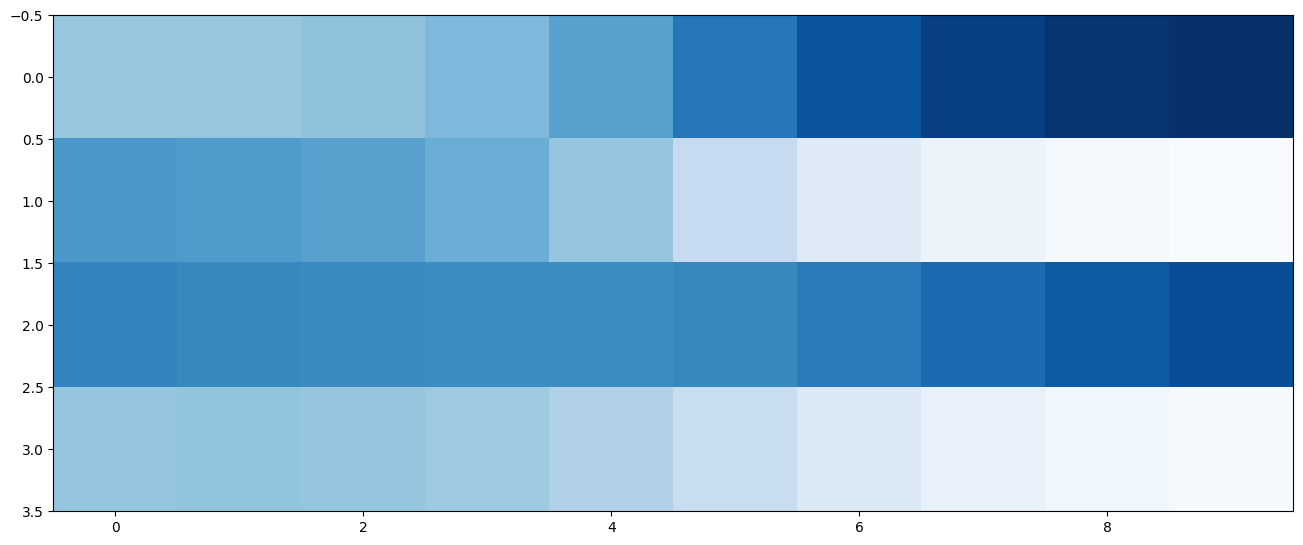

In [29]:
%%time
# 训练GAN

# 创建鉴别器和生成器
D = Discriminator()
G = Generator()

image_list = []

# 训练鉴别器和生成器
for i in range(10000):
  # 用真实样本训练鉴别器
  D.train(generate_real(), torch.FloatTensor([1.0]))

  # 用生成样本训练鉴别器
  # 使用detach()以避免计算生成器G的梯度
  D.train(G.forward(torch.FloatTensor([0.5])).detach(), torch.FloatTensor([0.0]))

  # 训练生成器
  G.train(D, torch.FloatTensor([0.5]), torch.FloatTensor([1.0]))

  # 每训练1000次记录图像
  if (i % 1000 == 0):
    image_list.append(G.forward(torch.FloatTensor([0.5])).detach().numpy())
  
plt.figure(figsize = (16, 8))
plt.imshow(np.array(image_list).T, interpolation='none', cmap='Blues')

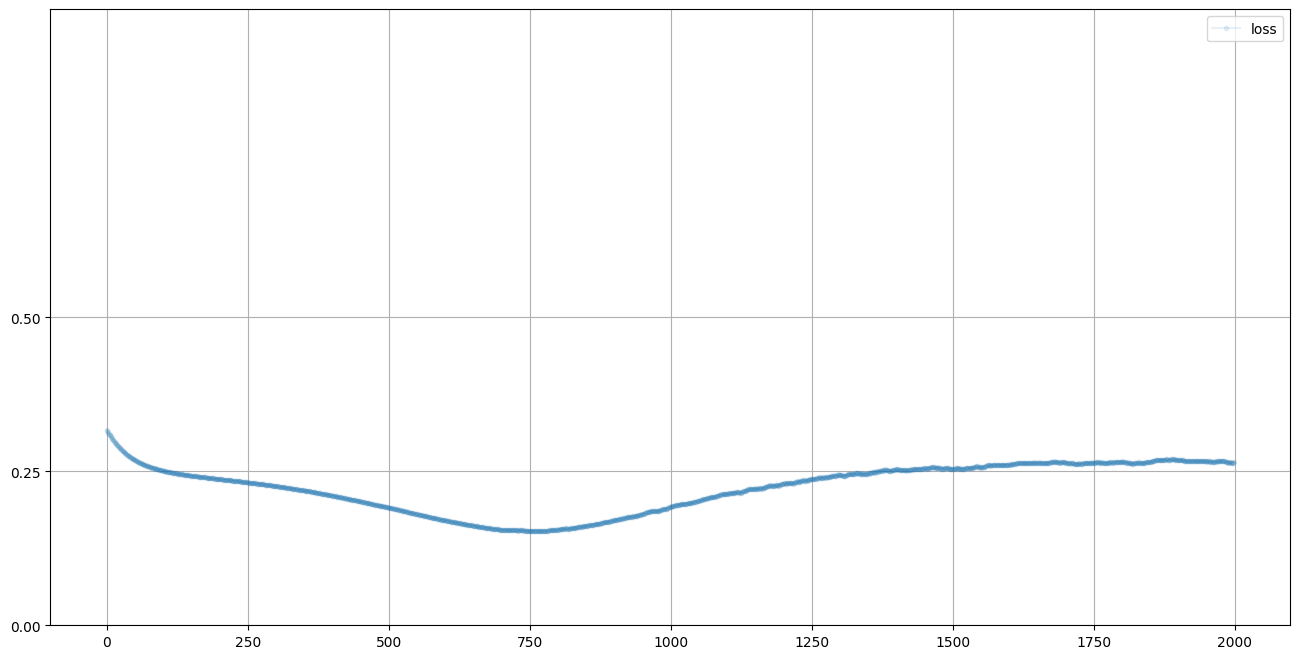

In [15]:
D.plot_progress()

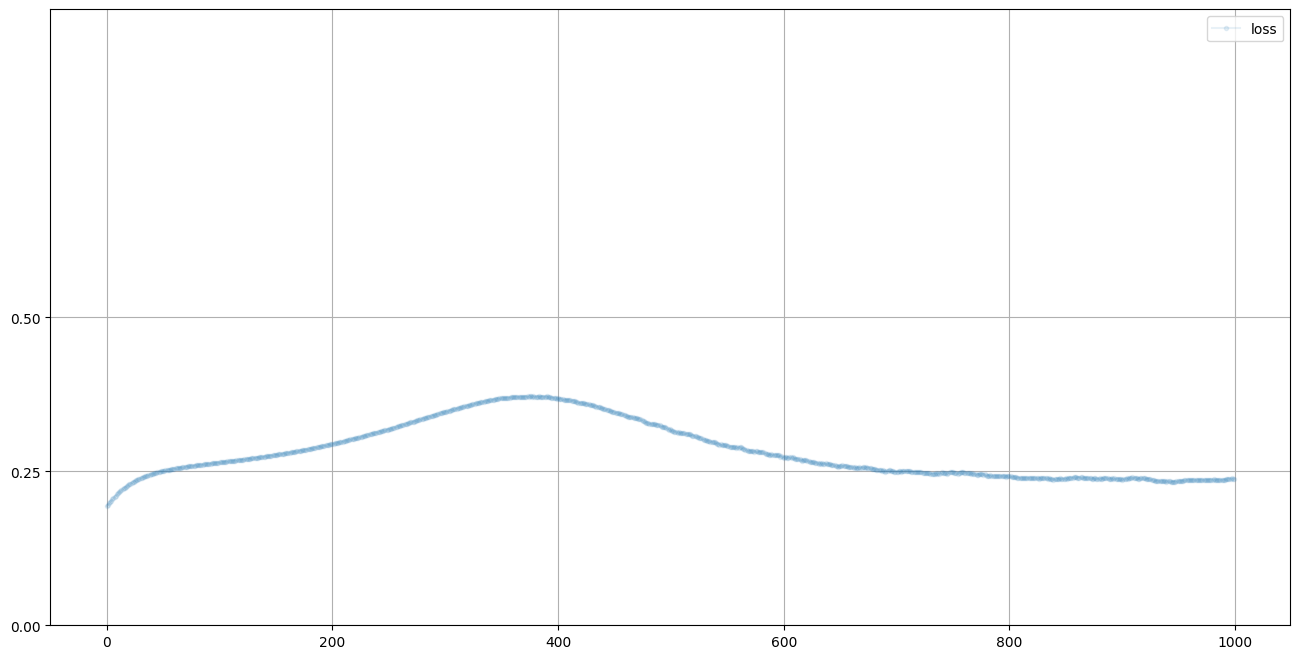

In [16]:
G.plot_progress()

In [22]:
G.forward(torch.FloatTensor([0.5]))

tensor([0.9421, 0.0547, 0.9038, 0.0637], grad_fn=<SigmoidBackward0>)